In [1]:
!pip install librosa pandas matplotlib scikeras resampy

## Step 1 : Load and Explore a Sample of the Dataset

Sampled Dataset Size: 1380
                                                   path  \
1380  Toronto Emotional Speech Set\YAF_angry\YAF_bar...   
2104  Toronto Emotional Speech Set\YAF_happy\YAF_rai...   
331   Toronto Emotional Speech Set\OAF_disgust\OAF_r...   
2423  Toronto Emotional Speech Set\YAF_pleasant_surp...   
1152  Toronto Emotional Speech Set\OAF_Pleasant_surp...   

                     emotion  
1380               YAF_angry  
2104               YAF_happy  
331              OAF_disgust  
2423  YAF_pleasant_surprised  
1152   OAF_Pleasant_surprise  


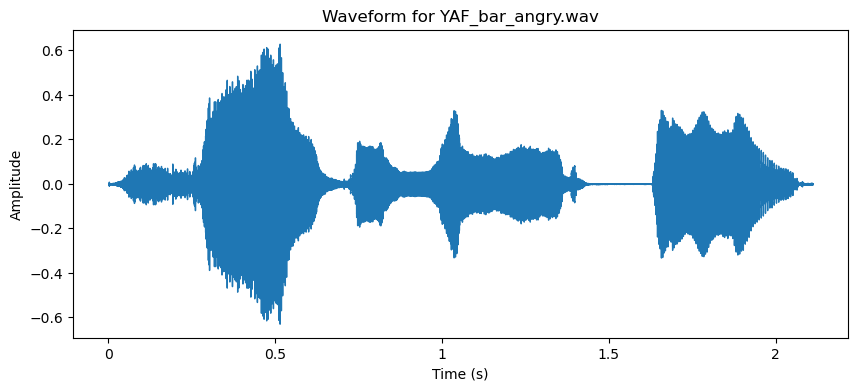

In [3]:
# Import necessary libraries
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the dataset path
dataset_path = r'Toronto Emotional Speech Set'

# Function to load dataset information
def load_dataset(dataset_path):
    emotions = os.listdir(dataset_path)
    data = []
    for emotion in emotions:
        emotion_path = os.path.join(dataset_path, emotion)
        for file in os.listdir(emotion_path):
            if file.endswith('.wav'):
                file_path = os.path.join(emotion_path, file)
                data.append({"path": file_path, "emotion": emotion})
    return pd.DataFrame(data)

# Load full dataset
data = load_dataset(dataset_path)

# Take a random sample -> 50% of the data
sampled_data = data.sample(frac=0.5, random_state=78)
print(f"Sampled Dataset Size: {len(sampled_data)}")
print(sampled_data.head())

# Sample visualization
def visualize_waveform(file_path):
    signal, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(f"Waveform for {os.path.basename(file_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Visualize one sample
sample_file = sampled_data['path'].iloc[0]
visualize_waveform(sample_file)

## Step 2 : Preprocessing

In [5]:
from sklearn.model_selection import train_test_split

# Function to preprocess a single audio file
def preprocess_audio(file_path, target_sr=22050):
    signal, sr = librosa.load(file_path, sr=target_sr)  # Load and resample audio
    normalized_signal = librosa.util.normalize(signal)  # Normalize amplitude
    return normalized_signal, sr

# Preprocess a sample file for demonstration
sample_signal, sample_sr = preprocess_audio(sample_file)
print(f"Processed signal shape: {sample_signal.shape}, Sampling rate: {sample_sr}")

# Split the dataset into training and testing sets
def split_data(data, test_size=0.2, random_state=42):
    return train_test_split(data, test_size=test_size, random_state=random_state, stratify=data['emotion'])

train_data, test_data = split_data(sampled_data)
print(f"Training set size: {len(train_data)}, Testing set size: {len(test_data)}")

Processed signal shape: (46552,), Sampling rate: 22050
Training set size: 1104, Testing set size: 276


## Step 3 : Feature Extraction

In [7]:
# Function to extract MFCC features from an audio file
def extract_features(file_path, n_mfcc=13, n_fft=2048, hop_length=512):
    signal, sr = preprocess_audio(file_path)  # Preprocess the audio
    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfccs_mean = mfccs.mean(axis=1)  # Average MFCCs over time
    return mfccs_mean

# Test the updated function with a sample file
sample_features = extract_features(sample_file)
print(f"Extracted MFCC features: {sample_features}")


# Extract features for the training and testing datasets
def extract_dataset_features(data, n_mfcc=13):
    features = []
    labels = []
    for _, row in data.iterrows():
        mfccs = extract_features(row['path'], n_mfcc=n_mfcc)
        features.append(mfccs)
        labels.append(row['emotion'])
    return np.array(features), np.array(labels)

# Extract features for training and testing sets
X_train, y_train = extract_dataset_features(train_data)
X_test, y_test = extract_dataset_features(test_data)

# Check feature shapes
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Extracted MFCC features: [-265.43527      42.57076      -7.9929547    -7.307866    -31.491417
   -2.163597     -3.1634703   -23.20806      -7.1725135    -0.70523256
  -18.451311     13.01643     -19.096918  ]
Training features shape: (1104, 13)
Testing features shape: (276, 13)


## Step 4 : Dimensionality Reduction

In [9]:
from sklearn.decomposition import PCA

# Function to apply PCA for dimensionality reduction
def apply_pca(X, n_components=10):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced, pca

# Apply PCA to training and testing features
n_components = 10  # You can experiment with this value
X_train_reduced, pca = apply_pca(X_train, n_components=n_components)
X_test_reduced = pca.transform(X_test)

# Check the shape of the reduced features
print(f"Reduced training features shape: {X_train_reduced.shape}")
print(f"Reduced testing features shape: {X_test_reduced.shape}")

# Explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance retained: {sum(pca.explained_variance_ratio_):.2f}")

Reduced training features shape: (1104, 10)
Reduced testing features shape: (276, 10)
Explained variance ratio: [0.38573512 0.31029254 0.12993087 0.0575842  0.0390593  0.02133521
 0.01585834 0.01113487 0.00869238 0.00724079]
Total variance retained: 0.99


## Step 5 : Building Classifiers

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Step 2: Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Step 3: Define function to train and evaluate models
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

Logistic Regression Results:
Accuracy: 0.86

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.79      0.75      0.77        20
 OAF_Pleasant_surprise       0.43      0.53      0.48        19
               OAF_Sad       0.95      1.00      0.98        21
             OAF_angry       0.85      0.85      0.85        20
           OAF_disgust       0.67      0.64      0.65        22
             OAF_happy       0.73      0.55      0.63        20
           OAF_neutral       1.00      1.00      1.00        20
             YAF_angry       0.90      0.90      0.90        20
           YAF_disgust       1.00      1.00      1.00        19
              YAF_fear       0.86      1.00      0.93        19
             YAF_happy       1.00      0.84      0.91        19
           YAF_neutral       1.00      1.00      1.00        18
YAF_pleasant_surprised       0.86      0.95      0.90        19
               YAF_sad       1.00  

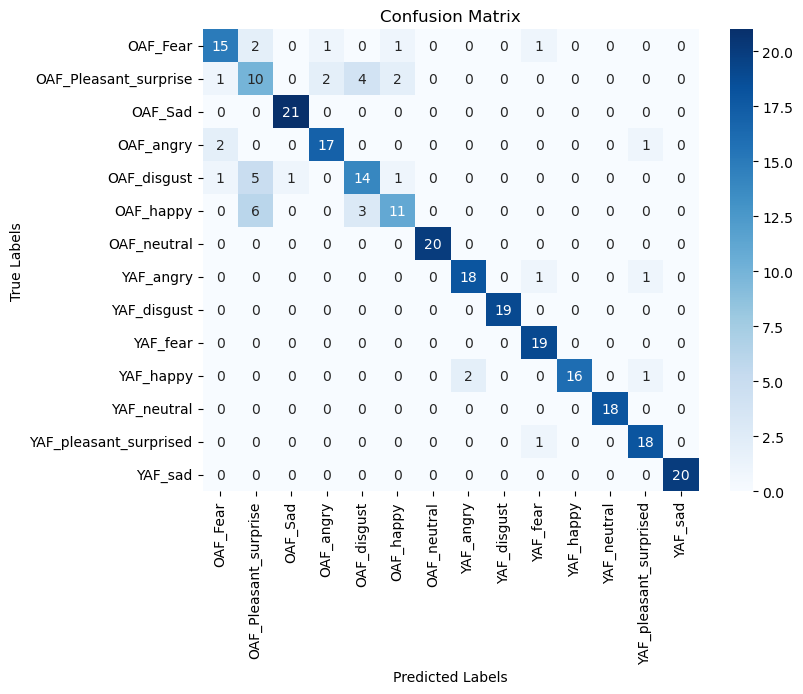

In [12]:
# Step 4: Train and evaluate classifiers
# 1) Logistic Regression
print("Logistic Regression Results:")
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
train_and_evaluate_model(log_reg, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


Support Vector Machines Results:
Accuracy: 0.88

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.83      0.95      0.88        20
 OAF_Pleasant_surprise       0.53      0.53      0.53        19
               OAF_Sad       1.00      1.00      1.00        21
             OAF_angry       0.90      0.90      0.90        20
           OAF_disgust       0.77      0.77      0.77        22
             OAF_happy       0.76      0.65      0.70        20
           OAF_neutral       1.00      1.00      1.00        20
             YAF_angry       0.90      0.90      0.90        20
           YAF_disgust       1.00      1.00      1.00        19
              YAF_fear       0.89      0.89      0.89        19
             YAF_happy       0.89      0.84      0.86        19
           YAF_neutral       1.00      1.00      1.00        18
YAF_pleasant_surprised       0.90      0.95      0.92        19
               YAF_sad       1

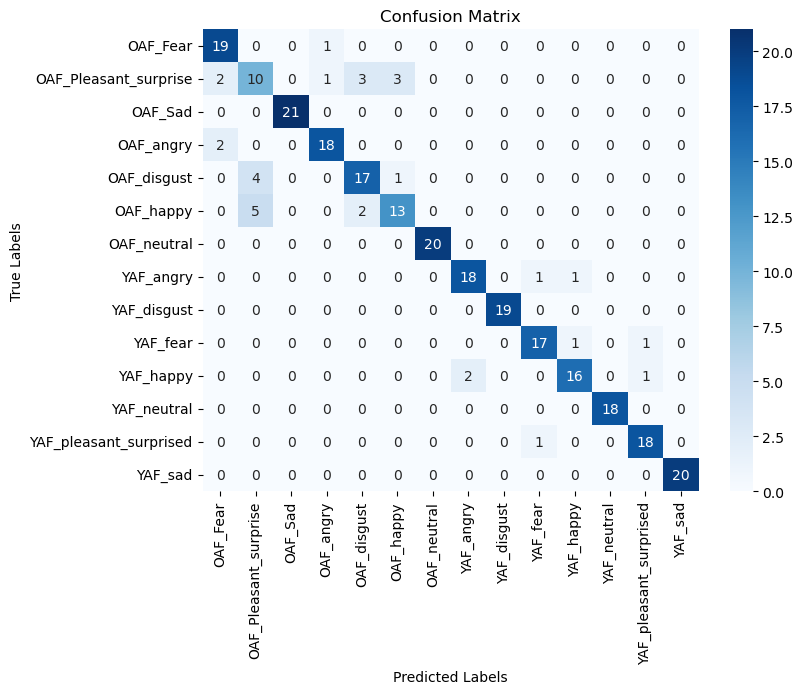

In [13]:
# 2) Support Vector Machines
print("\nSupport Vector Machines Results:")
svm = SVC(kernel='linear', class_weight='balanced', random_state=42)
train_and_evaluate_model(svm, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


K-Nearest Neighbors Results:
Accuracy: 0.86

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.73      0.95      0.83        20
 OAF_Pleasant_surprise       0.50      0.42      0.46        19
               OAF_Sad       0.95      1.00      0.98        21
             OAF_angry       0.90      0.90      0.90        20
           OAF_disgust       0.70      0.64      0.67        22
             OAF_happy       0.72      0.65      0.68        20
           OAF_neutral       0.95      1.00      0.98        20
             YAF_angry       0.86      0.95      0.90        20
           YAF_disgust       1.00      1.00      1.00        19
              YAF_fear       0.86      0.95      0.90        19
             YAF_happy       1.00      0.79      0.88        19
           YAF_neutral       0.94      0.89      0.91        18
YAF_pleasant_surprised       0.89      0.84      0.86        19
               YAF_sad       0.95 

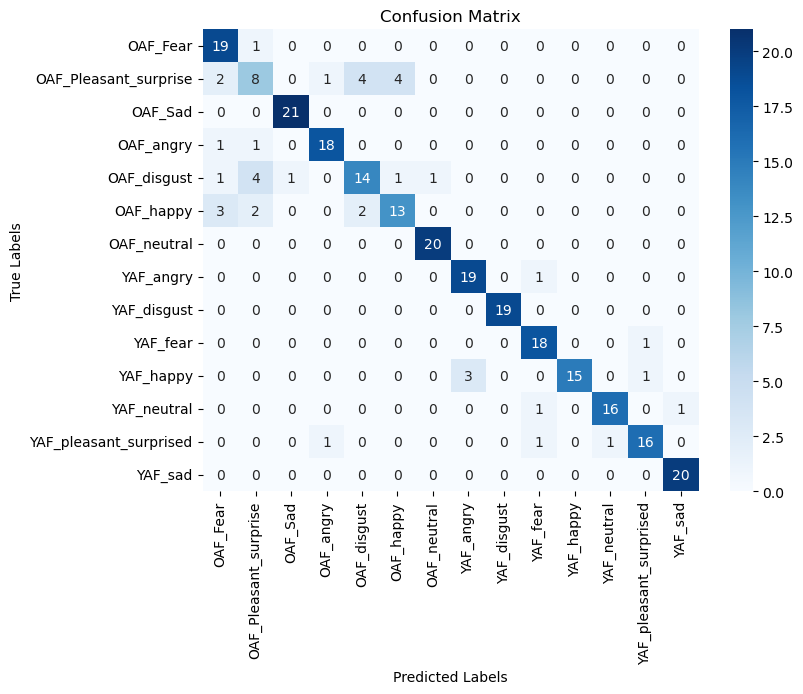

In [14]:
# 3) K-Nearest Neighbors
print("\nK-Nearest Neighbors Results:")
knn = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(knn, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


Random Forest Results:
Accuracy: 0.84

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.89      0.85      0.87        20
 OAF_Pleasant_surprise       0.60      0.63      0.62        19
               OAF_Sad       0.91      1.00      0.95        21
             OAF_angry       0.95      0.90      0.92        20
           OAF_disgust       0.61      0.77      0.68        22
             OAF_happy       0.82      0.45      0.58        20
           OAF_neutral       0.89      0.85      0.87        20
             YAF_angry       0.80      0.80      0.80        20
           YAF_disgust       0.95      0.95      0.95        19
              YAF_fear       0.75      0.95      0.84        19
             YAF_happy       0.94      0.84      0.89        19
           YAF_neutral       0.95      1.00      0.97        18
YAF_pleasant_surprised       0.88      0.79      0.83        19
               YAF_sad       0.95      1

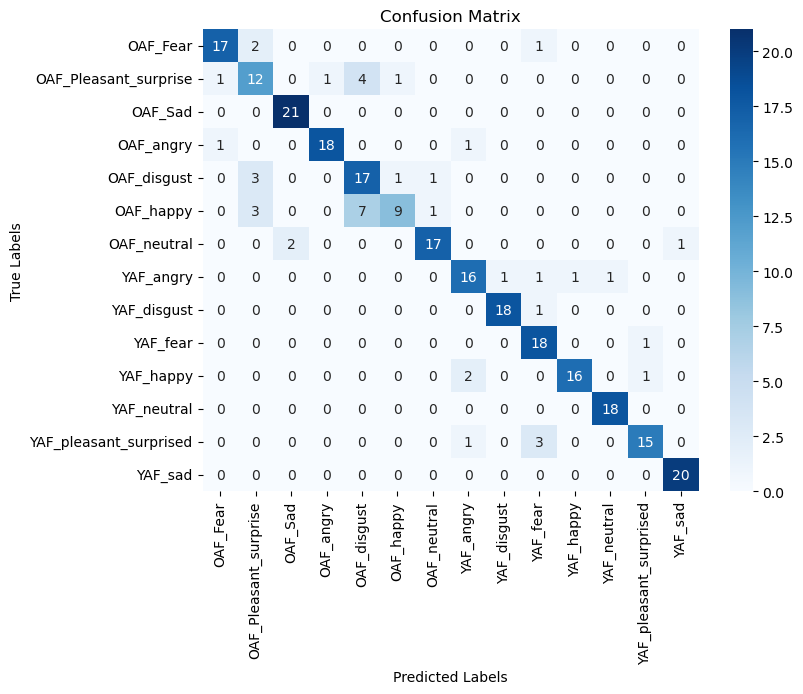

In [15]:
# 4) Random Forest Classifier
print("\nRandom Forest Results:")
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
train_and_evaluate_model(rf, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

## Step 6: Evaluation and Model Selection

Evaluating model: Logistic Regression
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Evaluating model: SVM
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Evaluating model: KNN
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Evaluating model: Random Forest
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Model Comparison:
                 Model  Accuracy  Precision (macro avg)  Recall (macro avg)  F1-Score (macro avg)
1         

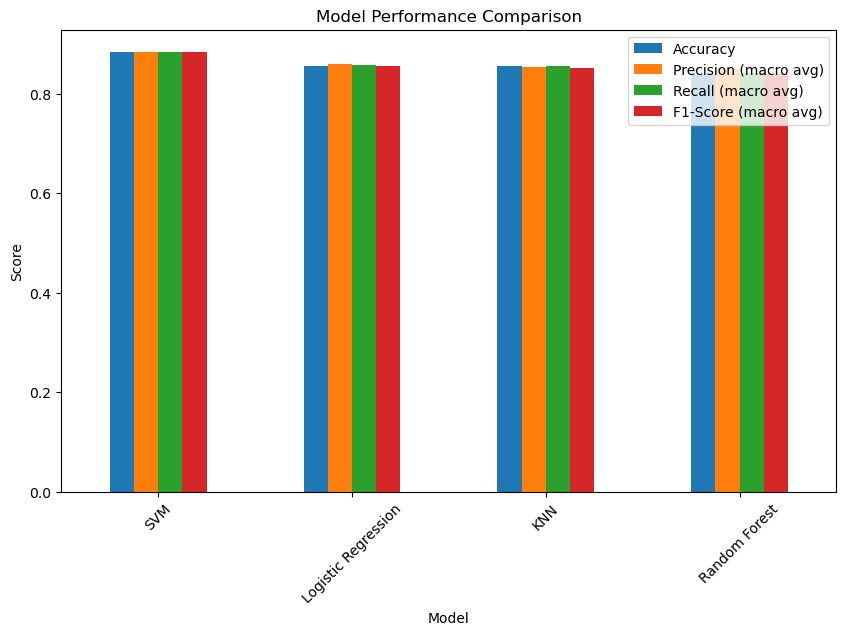

In [17]:
# Ensure label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_balanced = label_encoder.fit_transform(y_train_balanced)
y_test = label_encoder.transform(y_test)

# Initialize a dictionary to store evaluation metrics
results = []

# Helper function to evaluate models and store results
def evaluate_model(name, model, X_test, y_test):
    """
    Evaluate the model and store metrics for comparison.
    Args:
        name (str): Name of the classifier.
        model: Trained model.
        X_test: Test feature matrix.
        y_test: Test labels.
    Returns:
        None
    """
    print(f"Evaluating model: {name}")

    # Make predictions
    y_pred = model.predict(X_test)

    # If y_pred contains class names, transform them to encoded integers
    if isinstance(y_pred[0], str):
        y_pred = label_encoder.transform(y_pred)

    print(f"y_test type: {type(y_test[0])}, unique values: {np.unique(y_test)}")
    print(f"y_pred type: {type(y_pred[0])}, unique values: {np.unique(y_pred)}")

    # Evaluate metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

    # Append results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (macro avg)": report["macro avg"]["precision"],
        "Recall (macro avg)": report["macro avg"]["recall"],
        "F1-Score (macro avg)": report["macro avg"]["f1-score"],
    })


# Evaluate traditional classifiers
evaluate_model("Logistic Regression", log_reg, X_test_scaled, y_test)
evaluate_model("SVM", svm, X_test_scaled, y_test)
evaluate_model("KNN", knn, X_test_scaled, y_test)
evaluate_model("Random Forest", rf, X_test_scaled, y_test)

# Create DataFrame for results
results_df = pd.DataFrame(results)

# Sort results by Accuracy (descending order)
pd.set_option('display.expand_frame_repr', False)
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("Model Comparison:")
print(results_df)

# Find the best model
best_model_row = results_df.iloc[0]
print(f"\nBest Model: {best_model_row['Model']} with Accuracy: {best_model_row['Accuracy']:.2f}")
best_model_name = best_model_row["Model"]

# Visualize results
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

## Step 7 : Checking Output using Best Model

In [43]:
import os
import random
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler

# Define the path to the unused dataset folder
new_data_folder = './unused_dataset'

# Define emotion mapping based on file prefixes
emotion_mapping = {
    "angry": "Angry",
    "disgust": "Disgust",
    "fear": "Fear",
    "neutral": "Neutral",
    "ps": "Pleasant Surprise",
    "pleasant_surprise": "Pleasant Surprise",
    "sad": "Sad",
    "happy": "Happy"
}

# Function to extract MFCC features
def extract_features(file_path, n_mfcc=10):
    """Extracts MFCC features from a .wav file."""
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# Preprocess and predict for Logistic Regression, SVM, KNN, and Random Forest
def run_ml_model(model, file_paths, n_mfcc=10):
    """Preprocess and predict emotions using traditional ML models."""
    # Extract features
    features = np.array([extract_features(file, n_mfcc=n_mfcc) for file in file_paths])
    
    # Standardize the features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Predict using the model
    predicted_labels = model.predict(features)
    return predicted_labels

# Extract emotion from file name
def extract_emotion_from_filename(file_name):
    """Extract emotion from file name using predefined mapping."""
    for key in emotion_mapping.keys():
        if key in file_name.lower():
            return emotion_mapping[key]
    return "Unknown"

# Select 3 random files for testing
all_files = [os.path.join(new_data_folder, f) for f in os.listdir(new_data_folder) if f.endswith('.wav')]
selected_files = random.sample(all_files, min(3, len(all_files)))

# Models dictionary
models = {
    "Logistic Regression": log_reg,
    "SVM": svm,
    "KNN": knn,
    "Random Forest": rf,
}

# Determine the best model dynamically
best_model_row = results_df.iloc[0]  # Assuming results_df is sorted by accuracy
best_model_name = best_model_row["Model"]
print(f"\nBest Model: {best_model_name} with Accuracy: {best_model_row['Accuracy']:.2f}")

# Select the best model
best_model = models[best_model_name]

# Predict emotions using the best model
predicted_labels = run_ml_model(best_model, selected_files)

# Display predictions
for file, label in zip(selected_files, predicted_labels):
    emotion = extract_emotion_from_filename(file)
    print(f"File: {os.path.basename(file)} --> Predicted Emotion: {emotion}")


Best Model: SVM with Accuracy: 0.88
File: YAF_chalk_neutral.wav --> Predicted Emotion: Neutral
File: YAF_moon_sad.wav --> Predicted Emotion: Sad
File: OAF_book_happy.wav --> Predicted Emotion: Happy
